In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240310%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240310T074323Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72dc36329153749ab4104d08a658a68519596ad2bf23f43a10b3ad92bef4eb6620713f0d80aa401cf8658c50811d4de77bc6be92cdbfa81186d6629a8ffb6f96811a49e645a72fead503e36a224d752155de7632663fe73828f1f5d1fbfd556cb126a92eb1d4a52bd269351b680911aac01a0fd622ff6212d82066212a0828e961fa580e5c281414f4f4ffce6b945b7f27d0daa8f9f0762271f3ef842277f4c08990185876ab17580bac5432e66ea9c864444b1d16dc7b77ae881cd2f765e0b8d6b0977eeb256ec016892c05892861b5b18558bd569c7a2de0b065573f33b4cfb858e7ab745240d7955eb3f9aab9086600ab07e8047397799c09a902c1ebe7cb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
Data source import complete.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings(action="ignore")

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
utkface = "/kaggle/input/utkface-new"

data = {"age":[], "gender":[], "image":[]}

for dir_1 in os.listdir(utkface):
    if dir_1 == "UTKFace":
        link_1 = os.path.join(utkface, dir_1)
        for dir_2 in os.listdir(link_1):
            data["age"].append(dir_2.split("_")[0])
            data["gender"].append(dir_2.split("_")[1])
            data["image"].append(os.path.join(link_1, dir_2))
    else:
        continue


df = pd.DataFrame(data)

print(df.shape)

df.head()

(23708, 3)


,age,gender,image
0,22,0,/kaggle/input/utkface-new/UTKFace/22_0_0_20170...
1,41,0,/kaggle/input/utkface-new/UTKFace/41_0_4_20170...
2,20,1,/kaggle/input/utkface-new/UTKFace/20_1_2_20170...
3,42,0,/kaggle/input/utkface-new/UTKFace/42_0_0_20170...
4,1,1,/kaggle/input/utkface-new/UTKFace/1_1_2_201612...


In [7]:
gender = {0:"Male", 1:"Female"}

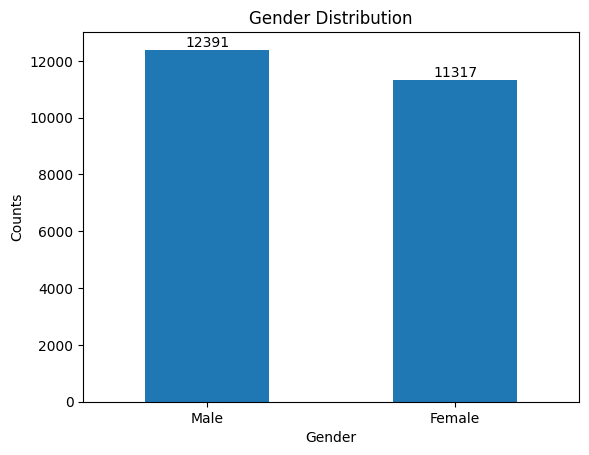

In [8]:
gender_dist = df["gender"].value_counts().plot(kind="bar")

for p in gender_dist.patches:
    h = p.get_height()
    gender_dist.text(p.get_x()+(p.get_width()/2), h, h, ha="center", va="bottom")

gender_dist.set_xlabel("Gender")
gender_dist.set_ylabel("Counts")
gender_dist.set_xticklabels(["Male", "Female"], rotation=360)
gender_dist.set_title("Gender Distribution")
plt.show()

In [9]:
for i in ["age", "gender"]:
    df[i] = df[i].astype("int")

In [10]:
df[["age", "gender"]].describe().T.style.background_gradient(cmap="coolwarm")

,count,mean,std,min,25%,50%,75%,max
age,23708.000000,33.303484,19.886112,1.000000,23.000000,29.000000,45.000000,116.000000
gender,23708.000000,0.477349,0.499497,0.000000,0.000000,0.000000,1.000000,1.000000


In [11]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)

In [12]:
df["age_category"] = age_binned

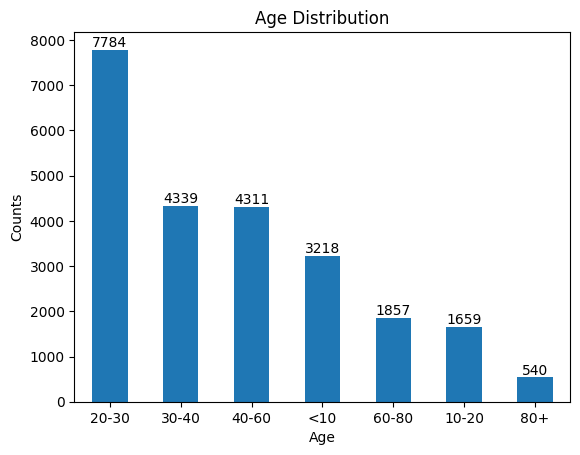

In [13]:
binned_age_dist = df["age_category"].value_counts().plot(kind="bar")

for p in binned_age_dist.patches:
    h = p.get_height()
    binned_age_dist.text(p.get_x()+(p.get_width()/2), h, h, ha="center", va="bottom")

binned_age_dist.set_xlabel("Age")
binned_age_dist.set_ylabel("Counts")
binned_age_dist.set_title("Age Distribution")
binned_age_dist.set_xticklabels(labels=binned_age_dist.get_xticklabels(), rotation=360)
plt.show()

## Train Test Split

In [14]:
df["gender"] = df["gender"].astype("str")

In [15]:
Xtrain, Xtest = train_test_split(df, test_size=0.1)

Xtest, Xval = train_test_split(Xtest, test_size=0.1)

print(Xtrain.shape, Xtest.shape, Xval.shape)

(21337, 4) (2133, 4) (238, 4)


In [32]:
from tensorflow.keras.applications import mobilenet, MobileNet, MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input, horizontal_flip=True)
train_generator_age = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input, horizontal_flip=True)
test_gen = ImageDataGenerator(preprocessing_function=mobilenet.preprocess_input)
test_gen_age = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)

In [33]:
age_datagen_train = train_generator.flow_from_dataframe(dataframe=Xtrain, x_col="image", y_col="age_category", target_size=(224, 224))
age_datagen_test = test_gen.flow_from_dataframe(dataframe=Xtest, x_col="image", y_col="age_category", target_size=(224, 224))
age_datagen_val = test_gen.flow_from_dataframe(dataframe=Xval, x_col="image", y_col="age_category", target_size=(224, 224))

gender_datagen_train = train_generator.flow_from_dataframe(dataframe=Xtrain, x_col="image", y_col="gender", target_size=(224, 224))
gender_datagen_test = test_gen.flow_from_dataframe(dataframe=Xtest, x_col="image", y_col="gender", target_size=(224, 224))
gender_datagen_val = test_gen.flow_from_dataframe(dataframe=Xval, x_col="image", y_col="gender", target_size=(224, 224))

Found 21337 validated image filenames belonging to 7 classes.
Found 2133 validated image filenames belonging to 7 classes.
Found 238 validated image filenames belonging to 7 classes.
Found 21337 validated image filenames belonging to 2 classes.
Found 2133 validated image filenames belonging to 2 classes.
Found 238 validated image filenames belonging to 2 classes.


## Modelling

In [18]:
from tensorflow.keras import Input

pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224, 3)))

17225924/17225924 [==============================] - 0s 0us/step


In [19]:
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [35]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19, vgg19


mobilenetv2_model = MobileNetV2(include_top=False, weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))
mobilenetv2_model.trainable = False
pretrained_model_output = mobilenetv2_model.output
x = layers.AveragePooling2D(pool_size=(2, 2))(pretrained_model_output)
x = layers.Flatten()(x)
# x = layers.Dense(units=1024, activation="relu")(x)
age_output = layers.Dense(units=7, activation="softmax", name="age_output")(x)

age_model = Model(inputs=mobilenetv2_model.input, outputs=[age_output])

age_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [21]:
from tensorflow.keras import regularizers

pretrained_model_output = pre_trained_model.output
x = layers.Flatten()(pretrained_model_output)
# x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=1024, activation="relu")(x)
gender_output = layers.Dense(units=2, activation="sigmoid", name="gender_output")(x)

gender_model = Model(inputs=[pre_trained_model.input], outputs=[gender_output])

gender_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [22]:
from tensorflow.keras import optimizers

gender_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=["categorical_crossentropy"],
                    metrics=["accuracy"])

In [23]:
from tensorflow.keras import callbacks

gender_model_history = gender_model.fit(gender_datagen_train,
                                        validation_data=gender_datagen_test,
                                        epochs=20,
                                        callbacks=[callbacks.ReduceLROnPlateau(patience=2),
                                                   callbacks.EarlyStopping(patience=10),
                                                   callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/model/gender.h5", save_best_only=True)])

Epoch 1/20
667/667 [==============================] - 124s 160ms/step - loss: 0.3659 - accuracy: 0.8590 - val_loss: 0.2476 - val_accuracy: 0.9011 - lr: 1.0000e-04
Epoch 2/20
667/667 [==============================] - 90s 135ms/step - loss: 0.1924 - accuracy: 0.9234 - val_loss: 0.2954 - val_accuracy: 0.8819 - lr: 1.0000e-04
Epoch 3/20
667/667 [==============================] - 100s 150ms/step - loss: 0.1370 - accuracy: 0.9458 - val_loss: 0.2178 - val_accuracy: 0.9194 - lr: 1.0000e-04
Epoch 4/20
667/667 [==============================] - 90s 134ms/step - loss: 0.1186 - accuracy: 0.9550 - val_loss: 0.3073 - val_accuracy: 0.8908 - lr: 1.0000e-04
Epoch 5/20
667/667 [==============================] - 91s 137ms/step - loss: 0.0930 - accuracy: 0.9672 - val_loss: 0.2755 - val_accuracy: 0.9137 - lr: 1.0000e-04
Epoch 6/20
667/667 [==============================] - 89s 134ms/step - loss: 0.0479 - accuracy: 0.9836 - val_loss: 0.2579 - val_accuracy: 0.9245 - lr: 1.0000e-05
Epoch 7/20
667/667 [======

In [24]:
gender_model.evaluate(gender_datagen_val)

8/8 [==============================] - 1s 132ms/step - loss: 0.2576 - accuracy: 0.9286


[0.25762176513671875, 0.9285714030265808]

<Axes: >

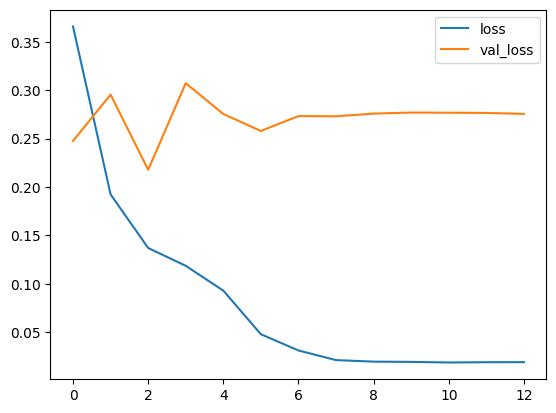

In [25]:
pd.DataFrame(gender_model_history.history)[["loss", "val_loss"]].plot()

In [36]:
age_model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                    loss=["categorical_crossentropy"],
                    metrics=["accuracy"])

In [37]:
age_model_history = age_model.fit(age_datagen_train,
                                  validation_data=age_datagen_test,
                                  epochs=20,
                                  callbacks=[callbacks.ReduceLROnPlateau(patience=2),
                                             callbacks.EarlyStopping(patience=10),
                                             callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/model/age.h5", save_best_only=True)])

Epoch 1/20
667/667 [==============================] - 51s 72ms/step - loss: 1.3739 - accuracy: 0.4769 - val_loss: 1.1783 - val_accuracy: 0.5499 - lr: 1.0000e-04
Epoch 2/20
667/667 [==============================] - 46s 68ms/step - loss: 1.1278 - accuracy: 0.5544 - val_loss: 1.1302 - val_accuracy: 0.5598 - lr: 1.0000e-04
Epoch 3/20
667/667 [==============================] - 46s 68ms/step - loss: 1.0299 - accuracy: 0.5886 - val_loss: 1.1026 - val_accuracy: 0.5696 - lr: 1.0000e-04
Epoch 4/20
667/667 [==============================] - 45s 68ms/step - loss: 0.9597 - accuracy: 0.6155 - val_loss: 1.1194 - val_accuracy: 0.5767 - lr: 1.0000e-04
Epoch 5/20
667/667 [==============================] - 47s 70ms/step - loss: 0.9121 - accuracy: 0.6350 - val_loss: 1.0888 - val_accuracy: 0.5687 - lr: 1.0000e-04
Epoch 6/20
667/667 [==============================] - 45s 67ms/step - loss: 0.8667 - accuracy: 0.6524 - val_loss: 1.1019 - val_accuracy: 0.5649 - lr: 1.0000e-04
Epoch 7/20
667/667 [==============

In [39]:
age_model.evaluate(age_datagen_val)

8/8 [==============================] - 1s 146ms/step - loss: 1.1899 - accuracy: 0.5630


[1.1898726224899292, 0.5630252361297607]

## Observation:
* The models performance is bad and can be improved. I would make future adjustments as i make my research.